# Step 1: Install All the Required Packages

In [2]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 18.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 90.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.4 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires transformers>=4.33.1, but you have transformers 4.31.0 which is incompatible.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.31.0 which is incompatible.


# Step 2: Import All the Required Libraries

In [3]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

# In case of Llama 2, the following prompt template is used for the chat models
- System Prompt (optional) to guide the model

- User prompt (required) to give the instruction

- Model Answer (required)

 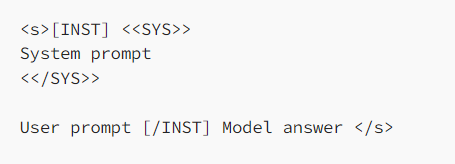

# Step 3 Load a llama-2-7b-chat-hf model (chat model)
- Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune
- QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

## Prepare the data

In [3]:
# dataset = load_dataset('timdettmers/openassistant-guanaco')
dataset = load_dataset('mlabonne/guanaco-llama2-1k', split="train")
# dataset

README.md:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

(…)-00000-of-00001-9ad84bb9cf65a42f.parquet:   0%|          | 0.00/967k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
def transform_conversation(example):
    conversation_text = example['text']
    segments = conversation_text.split('###')

    reformatted_segment = []
    
    for i in range(1, len(segments) - 1, 2):
        human_text = segments[i].strip().replace('Human:', '').strip()

        if i + 1 < len(segments):
            assistant_text = segments[i + 1].strip().replace('Assistant', '').strip()

            reformatted_segment.append(f'<s>[INST] {human_text} [/INST] {assistant_text} </s>')
        else:
            reformatted_segment.append(f'<s>[INST] {human_text} [INST] </s>')

    return {'text': ''.join(reformatted_segment)}
        

In [5]:
# dataset = dataset['train'].shuffle(seed = 42).select(range(1000))
# transformed_dataset = dataset.map(transform_conversation)

In [12]:
model_name = "NousResearch/Llama-2-7b-chat-hf"
new_model = 'Llama-2-7b-chat-finetune'
dataset_name = "mlabonne/guanaco-llama2-1k"

## QLoRA Parameter

In [7]:
#Lora Attention Dimension
lora_r = 64

# alpha parameter for lora
lora_alpha = 16

# dropout probability for lora layers
lora_dropout = 0.1

## BitsAndBytes Parameter

In [8]:
# 4-bit precision Base model loadingl
use_4bit = True

# compute dtype for 4bit base model
bnb_4bit_compute_dtype = 'float16'

# Quantization type
bnb_4bit_quant_type = 'nf4'

# activate nested quantization for base model (double quantization)
use_nested_quant = False

## TrainingArguments parameter

In [9]:
output_dir = './results'

num_train_epochs = 1

# Enable fp16/bf16 training
fp16 = False
bf16 = False

per_device_train_batch_size = 4
per_device_eval_batch_size = 4

gradient_accumulation_steps = 1 # Number of update steps to accumulate the gradients for
gradient_checkpointing = True # Enable gradient checkpointing

max_grad_norms = 0.3 # Maximum gradient normal (gradient clipping)

learning_rate = 2e-4 # Initial learning rate (AdamW optimizer)

weight_decay = 0.001 # Weight decay to apply to all layers except bias/LayerNorm weights

optim = 'paged_adamw_32bit' # Optimizer to use

lr_scheduler_type = 'cosine' # Learning rate schedule
max_steps = -1 # Number of training steps (overrides num_train_epochs)

warmup_ratio = 0.03 # Ratio of steps for a linear warmup (from 0 to learning rate)

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

save_steps = 0 # Save checkpoint every X updates steps

logging_steps = 25 # Log every X updates steps

## SFTTrainer Parameter

In [10]:
# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = 'auto'

# Step 4:Load everything and start the fine-tuning process

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.
2. Then, we’re configuring bitsandbytes for 4-bit quantization.
3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.
4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!


In [11]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

In [12]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_configuration = BitsAndBytesConfig(
    load_in_4bit = use_4bit,
    bnb_4bit_quant_type = bnb_4bit_quant_type,
    bnb_4bit_compute_dtype = bnb_4bit_compute_dtype,
    bnb_4bit_use_double_quant = use_nested_quant,
)

In [13]:
# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()

    if major >= 8:
        print('='*10)
        print('gpu support bfloat16')
        print('='*10)

In [14]:
# load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_configuration,
    device_map = device_map
)

model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [15]:
# load Llama tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code = True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [16]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha = lora_alpha,
    lora_dropout = lora_dropout,
    r = lora_r,
    bias = 'none',
    task_type = 'CAUSAL_LM',
)

In [17]:
# set training parameter
training_arguments = TrainingArguments(
    output_dir = output_dir,
    num_train_epochs = num_train_epochs,
    per_device_train_batch_size = per_device_train_batch_size,
    gradient_accumulation_steps = gradient_accumulation_steps,
    max_grad_norm = max_grad_norms,
    max_steps = max_steps,
    optim = optim,
    save_steps = save_steps,
    logging_steps = logging_steps,
    learning_rate = learning_rate,
    weight_decay = weight_decay,
    fp16 = fp16,
    bf16 = bf16,
    warmup_ratio = warmup_ratio,
    group_by_length = group_by_length,
    lr_scheduler_type = lr_scheduler_type,
    report_to = 'tensorboard'
)

In [18]:
# Set SFTTrainer - Supervised Fine Tuning parameter
trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    peft_config = peft_config,
    dataset_text_field = 'text',
    max_seq_length = max_seq_length,
    tokenizer = tokenizer,
    args = training_arguments,
    packing = packing
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=250, training_loss=1.361824951171875, metrics={'train_runtime': 1777.9778, 'train_samples_per_second': 0.562, 'train_steps_per_second': 0.141, 'total_flos': 8755214190673920.0, 'train_loss': 1.361824951171875, 'epoch': 1.0})

In [19]:
trainer.model.save_pretrained(new_model)

# Step 5: Load the model

In [26]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)

chatbot = PeftModel.from_pretrained(base_model, new_model)
chatbot = chatbot.merge_and_unload()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code = True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

In [60]:
pipe = pipeline('text-generation', model = chatbot, tokenizer = tokenizer, max_length=1024)

In [61]:
prompt = "write a program to print first fibonacci no."
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] write a program to print first fibonacci no. [/INST] Sure! Here is a program that prints the first Fibonacci number:

def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n-1) + fibonacci(n-2)

print(fibonacci(5)) # prints 5

This program uses a recursive function called fibonacci to calculate the nth Fibonacci number. The function takes an integer n as input and returns the nth Fibonacci number. The function uses a base case where n is less than or equal to 1, in which case the function returns n directly. Otherwise, the function calls itself with n-1 and n-2 as arguments, and then adds the results to get the final answer.

I hope this helps! Let me know if you have any questions.
